# 1. Importieren der benötigten Bibliotheken für das ML-Training

In [ ]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn, cuda
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim import Adam
import torch.optim as optim
from tqdm import tqdm
# from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
# from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn, cuda
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim import Adam
import torch.optim as optim
from tqdm import tqdm


In [ ]:
import pandas as pd
import os
import shutil

train_men = "C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/output2/train/men"
train_women = "C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/output2/train/women"
val_men = "C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/output2/val/men"
val_women = "C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/output2/val/women"
csv = "C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/source_csv/list_attr_celeba.csv"
folder = "C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/img_align_celeba"
train = "C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/output2/train"
test = "C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/output2/val"
def process_images(csv, folder, train_men, train_women, test_men, test_women, num_train, num_test):
    # Lese die CSV-Datei
    df = pd.read_csv(csv)

    # Extrahiere die 'Male'-Spalte
    male = df['Male']

    # Erstelle Listen für Männer- und Frauenbilder
    men_images = df[df['Male'] == 1]['image_id'].tolist()
    women_images = df[df['Male'] == -1]['image_id'].tolist()
    
    # men_features = [item for sublist in df[df['Male'] == 1].values.tolist()[:num_train] for item in sublist]
    # women_features = [item for sublist in df[df['Male'] == -1].values.tolist()[:num_train] for item in sublist]
    men_train_features = df[df['Male'] == 1][:num_train]
    women_train_features = df[df['Male'] == -1][:num_train]

    men_train_features.to_csv( train+ '/men_features.csv', index=False)
    women_train_features.to_csv( train+ '/women_features.csv', index=False)

  
    men_test_features = df[df['Male'] == 1][num_train:num_train+num_test]
    women_test_features = df[df['Male'] == -1][num_train:num_train+num_test]

    men_test_features.to_csv( test+ '/men_features.csv', index=False)
    women_test_features.to_csv( test+ '/women_features.csv', index=False)



    # Kopiere die ausgewählten Bilder in die Trainingsordner
    for img in men_images[:num_train]:
        shutil.copy(img, train_men)
    for img in women_images[:num_train]:
         shutil.copy(img, train_women)

    # Kopiere die ausgewählten Bilder in die Testordner
    for img in men_images[num_train:num_train+num_test]:
               shutil.copy(img, test_men)
    for img in women_images[num_train:num_train+num_test]:
        shutil.copy(img, test_women)

# Verwendung der Funktion
process_images(csv=csv, folder=folder, train_men=train_men,train_women=train_women,test_men=val_men,test_women=val_women,num_train=2000,num_test=1000)

In [ ]:
import pandas as pd
import os
import shutil

def process_images(source_csv, source_img_folder, output_folder_train_men, output_folder_train_women, num_images):
    # Lese die CSV-Datei
    df = pd.read_csv(source_csv)

    # Extrahiere die 'Male'-Spalte
    male = df['Male']

    # Erstelle Listen für Männer- und Frauenbilder
    men_images = df[df['Male'] == 1]['image_id'].tolist()[:num_images]
    women_images = df[df['Male'] == -1]['image_id'].tolist()[:num_images]
  
     # Kopiere die restlichen Bilder in die Validierungsordner, wenn sie nicht bereits in den Trainingsordnern vorhanden sind
    for img in men_images[num_images:]:
        if not os.path.exists(os.path.join(output_folder_train_men, img)):
            shutil.copy(img, output_folder_val_men)
    for img in women_images[num_images:]:
        if not os.path.exists(os.path.join(output_folder_train_women, img)):
            shutil.copy(img, output_folder_val_women)

# Verwendung der Funktion
process_images('C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/source_csv/list_attr_celeba.csv', 'C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/img_align_celeba', 'C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/output/train/men','C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/output/train/women', 2000)

# 2. ML-Training 

## 2.1 Festlegen der epochen und der Batchsize sowie die Transformierung der Daten in einen Tensor und dann noch normalisieren

In [ ]:
epochs = 100
batch_size = 64

def count_files(men_dir, women_dir):
    men_files = len(os.listdir(men_dir))
    women_files = len(os.listdir(women_dir))

    total_files = men_files + women_files

    print(f"Anzahl der Dateien in 'men': {men_files}")
    print(f"Anzahl der Dateien in 'women': {women_files}")
    print(f"Gesamtanzahl der Dateien: {total_files}")


# Transformation der Daten für das Training und Testen  
transform = transforms.Compose([
    transforms.Resize((178, 218)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Dateipfade für das Training und Testen festlegen
train_dataset = datasets.ImageFolder(root='C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/output2/train',transform=transform)
test_dataset = datasets.ImageFolder(root= 'C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/output2/val',transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## 2.2 Erstellen eines eigenen Datasets (falls notwendig)

In [ ]:

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
class GenderRecognitionDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 1])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[idx, 2]))
        if self.transform:
            image = self.transform(image)
        return (image,y_label)









## 2.3 Überprüfen ob die Bilder richtig angezeigt werden

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img = train_features[0].permute(1, 2, 0)
plt.imshow(img, cmap="gray")

## 2.4 Erstellen eines CNN-Modells

### Das CNN-Modell besteht aus 2 Convolutional Layers, 2 Pooling Layers, 2 Max Pooling Layers, 3 Dense Layers

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Erste Convolutional Layer. Nimmt 3 Eingangskanäle (RGB), gibt 6 Kanäle aus, mit einer Kernelgröße von 5
        self.conv1 = nn.Conv2d(3, 6, 5)  
        # Max-Pooling-Layer mit einem quadratischen Fenster der Kernelgröße=4, Schrittgröße=4
        self.pool = nn.MaxPool2d(2, 2)  
        # Zweite Convolutional Layer. Nimmt 6 Eingangskanäle (von der vorherigen Schicht), gibt 16 Kanäle aus, mit einer Kernelgröße von 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Max-Pooling-Layer mit einem quadratischen Fenster der Kernelgröße=2, Schrittgröße=2
        self.pool = nn.MaxPool2d(2,2) 
        # Erste vollständig verbundene Schicht. Nimmt einen abgeflachten Vektor der Größe 33456 auf, gibt einen Vektor der Größe 120 aus
        self.fc1 = nn.Linear(33456 , 120) 
        # Zweite vollständig verbundene Schicht. Nimmt einen Vektor der Größe 120 auf, gibt einen Vektor der Größe 84 aus
        self.fc2 = nn.Linear(120, 84)
        # Dritte vollständig verbundene Schicht. Nimmt einen Vektor der Größe 84 auf, gibt einen Vektor der Größe 2 aus
        self.fc3 = nn.Linear(84, 2) 

    def forward(self, x):
        # Anwendung der ersten Conv-Schicht, dann ReLU-Aktivierungsfunktion, dann Max-Pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Anwendung der zweiten Conv-Schicht, dann ReLU-Aktivierungsfunktion, dann Max-Pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Abflachen des Tensorausgangs von den Conv-Schichten
        x = x.view(x.size(0), -1) 
        # Anwendung der ersten vollständig verbundenen Schicht, dann ReLU-Aktivierungsfunktion
        x = F.relu(self.fc1(x))  
        # Anwendung der zweiten vollständig verbundenen Schicht, dann ReLU-Aktivierungsfunktion
        x = F.relu(self.fc2(x)) 
        # Anwendung der dritten vollständig verbundenen Schicht
        x = self.fc3(x)  
        return x

# 3. ML-Modell trainieren

## Dokumentation für PyTorch Trainingsskript

Dieses Skript trainiert ein Convolutional Neural Network (CNN) mit PyTorch.

## Variablen

- `model`: Eine Instanz des `SimpleCNN` Modells.
- `criterion`: Die Verlustfunktion, die während des Trainings verwendet wird. In diesem Fall wird die Cross-Entropy-Loss-Funktion verwendet.
- `optimizer`: Der Optimierer, der zur Aktualisierung der Modellparameter verwendet wird. Hier wird der Stochastic Gradient Descent (SGD) Optimierer verwendet.
- `patience`: Die Anzahl der Epochen, die auf eine Verbesserung der Genauigkeit gewartet wird, bevor das Training gestoppt wird.
- `best_accuracy`: Die beste Genauigkeit, die während des Trainings erreicht wurde. Initialisiert auf 0.
- `early_stopping_counter`: Zählt die Anzahl der Epochen ohne Verbesserung der Genauigkeit.

## Trainingsschleife

Das Modell wird für eine bestimmte Anzahl von Epochen trainiert. In jeder Epoche wird das Modell mit den Trainingsdaten trainiert und dann mit den Testdaten validiert.

Während des Trainings werden die Modellparameter aktualisiert, um den Verlust zu minimieren. Der Verlust wird berechnet, indem die Ausgabe des Modells und die tatsächlichen Labels verglichen werden.

Nach jeder Epoche wird die Genauigkeit des Modells auf den Testdaten berechnet. Wenn die Genauigkeit über 90% liegt, wird der aktuelle Zustand des Modells gespeichert. Wenn die Genauigkeit nicht besser ist als die bisher beste Genauigkeit, wird der `early_stopping_counter` erhöht. Wenn der `early_stopping_counter` den Wert von `patience` erreicht, wird das Training gestoppt.

## Ausgabe

Das Skript gibt den Verlust und die Genauigkeit nach jeder Epoche aus. Wenn das Training aufgrund von Early Stopping gestoppt wird, wird eine entsprechende Nachricht ausgegeben. Am Ende des Trainings wird eine Nachricht ausgegeben, dass das Training abgeschlossen ist.

In [ ]:

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
patience = 10 
best_accuracy = 0.0  
early_stopping_counter = 0  

for epoch in range(epochs): 
    running_loss = 0.0
    for i, data in enumerate(tqdm(train_dataloader), 0):
      
        inputs, labels = data

   
        optimizer.zero_grad()

   
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  

   
        running_loss += loss.item()

  
    correct = 0
    total = 0
    if i % 10 == 9: 
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 100))
        running_loss = 0.0
        
    with torch.no_grad():
        for val_data in test_dataloader:
            val_images, val_labels = val_data
            val_outputs = model(val_images)
            _, predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    accuracy = correct / total


    if accuracy > 0.9:  
        torch.save(model.state_dict(), f'model/PyTorch_Trained_Models/model_epoch_{epoch+1}_accuracy_{accuracy:.2f}.pth')
   
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        early_stopping_counter = 0
        print(f"Genauigkeit: {accuracy:.2f}")
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print('Early stopping')
        break

print('Finished Training')

model_path_git = f'model/PyTorch_Trained_Models/'
model_test_path = f'test/model_to_be_tested'

torch.save(model.state_dict(), f'{model_path_git}model_git{batch_size}' + '-' + f'{epochs}' + '.pth')
torch.save(model.state_dict(), f'{model_test_path}' + '.pth')

# 4 ML-Model Testen

## 4.1 PyTorch Modell Inferenz

### PyTorch Modell Inferenz

Dieser Codeblock führt Inferenz (Vorhersagen) auf einem Testdatensatz mit einem vortrainierten PyTorch Modell durch.

##### Modellpfad und Gerätekonfiguration

```python
model_path = f'{model_path_git}model_git{batch_size}' + '-' + f'{epochs}' + '.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
```

Zuerst wird der Pfad zum vortrainierten Modell erstellt, indem der Basispfad, der Name des Modells, die Batch-Größe und die Anzahl der Epochen kombiniert werden. Dann wird das Gerät auf "cuda" gesetzt, wenn eine GPU verfügbar ist, sonst auf "cpu".

##### Modellinitialisierung und Gewichtsladung

```python
model = SimpleCNN()
model.load_state_dict(torch.load(model_path))
```

Ein neues Modell wird erstellt (in diesem Fall ein einfaches CNN). Das Modell wird dann mit den Gewichten geladen, die unter dem angegebenen Pfad gespeichert sind.

##### Inferenz auf dem Testdatensatz

```python
for inputs, _ in test_dataloader:
    inputs = inputs.to(device) 
    output = model(inputs)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    predictions_list = predictions.cpu().numpy().tolist()
    print(predictions_list)
```

Für jede Eingabe im Testdatensatz werden die Eingaben auf das Gerät verschoben (GPU oder CPU). Das Modell macht dann eine Vorhersage auf den Eingaben. Die Ausgabe des Modells wird in Wahrscheinlichkeiten umgewandelt, indem die Softmax-Funktion angewendet wird. Die Klasse mit der höchsten Wahrscheinlichkeit wird als Vorhersage ausgewählt. Schließlich werden die Vorhersagen in eine Liste umgewandelt und ausgegeben.



In [ ]:
# Der Pfad zum Modell wird erstellt, indem der Basispfad, der Name des Modells, die Batch-Größe und die Anzahl der Epochen kombiniert werden.
model_path = f'{model_path_git}model_git{batch_size}' + '-' + f'{epochs}' + '.pth'

# Das Gerät wird auf "cuda" gesetzt, wenn eine GPU verfügbar ist, sonst auf "cpu".
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ein neues Modell wird erstellt (in diesem Fall ein einfaches CNN).
model = SimpleCNN()

# Das Modell wird mit den Gewichten geladen, die unter dem angegebenen Pfad gespeichert sind.
model.load_state_dict(torch.load(model_path))

# Ein DataLoader für den Testdatensatz wird erstellt (diese Zeile ist auskommentiert).
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Für jede Eingabe im Testdatensatz:
for inputs, _ in test_dataloader:
    # Die Eingaben werden auf das Gerät verschoben (GPU oder CPU).
    inputs = inputs.to(device) 
    # Das Modell macht eine Vorhersage auf den Eingaben.
    output = model(inputs)
    # Die Ausgabe des Modells wird in Wahrscheinlichkeiten umgewandelt, indem die Softmax-Funktion angewendet wird.
    probabilities = torch.nn.functional.softmax(output, dim=1)
    # Die Klasse mit der höchsten Wahrscheinlichkeit wird als Vorhersage ausgewählt.
    predictions = torch.argmax(probabilities, dim=1)
    # Die Vorhersagen werden in eine Liste umgewandelt und ausgegeben.
    predictions_list = predictions.cpu().numpy().tolist()
    print(predictions_list)

## 4.2 PyTorch Modell Inferenz und Genauigkeitsberechnung

Dieser Codeblock führt Inferenz (Vorhersagen) auf einem Testdatensatz mit einem vortrainierten PyTorch Modell durch und berechnet die Genauigkeit der Vorhersagen.

### Modellladen und Testdaten-Loader

```python
model = SimpleCNN()
model.load_state_dict(torch.load(model_path))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
```

Zuerst wird ein neues Modell erstellt (in diesem Fall ein einfaches CNN) und mit den Gewichten geladen, die unter dem angegebenen Pfad gespeichert sind. Dann wird ein DataLoader für den Testdatensatz erstellt, mit einer Batch-Größe von 64 und ohne Shuffle.

### Inferenz und Genauigkeitsberechnung

```python
correct = 0
total = 0

for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Genauigkeit des Modells auf Testbilder: {}%'.format(100 * accuracy))
```

Zwei Zähler werden initialisiert: `correct` für die Anzahl der korrekten Vorhersagen und `total` für die Gesamtzahl der Vorhersagen. Für jede Eingabe und das zugehörige Label im Testdatensatz werden die Eingaben und Labels auf das Gerät verschoben (GPU oder CPU). Das Modell macht dann eine Vorhersage auf den Eingaben und die Klasse mit der höchsten Ausgabe wird als Vorhersage ausgewählt. Die `total` und `correct` Zähler werden entsprechend aktualisiert. Schließlich wird die Genauigkeit berechnet als das Verhältnis von `correct` zu `total` und ausgegeben.



In [ ]:
# Model laden
model = SimpleCNN()
# model.load_state_dict(torch.load(f'model/model{batch_size}' + '-' + f'{epochs}' + '.pth'))
model.load_state_dict(torch.load(model_path))
# Assume `test_dataset` is your ImageFolder dataset
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Model für die Predictions und Genauigkeitberechnung verwenden
correct = 0
total = 0

for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

# Genauigkeit berechnen
accuracy = correct / total
print('Genauigkeit des Modells auf Testbilder: {}%'.format(100 * accuracy))


## 4.3 PyTorch Modell Inferenz und Metrikenberechnung

Dieser Codeblock führt Inferenz (Vorhersagen) auf einem Testdatensatz mit einem vortrainierten PyTorch Modell durch und berechnet verschiedene Metriken zur Beurteilung der Modellleistung.

### Modell Evaluierung und Inferenz

```python
model.eval() 
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted)
        true_labels.extend(labels)
```

Zuerst wird das Modell in den Evaluierungsmodus gesetzt. Dann werden zwei Listen initialisiert: `predictions` für die Vorhersagen des Modells und `true_labels` für die tatsächlichen Labels. Für jede Eingabe und das zugehörige Label im Testdatensatz macht das Modell eine Vorhersage und die Klasse mit der höchsten Ausgabe wird als Vorhersage ausgewählt. Die Vorhersagen und tatsächlichen Labels werden den entsprechenden Listen hinzugefügt.

### Konvertierung in numpy-Arrays und Metrikenberechnung

```python
predictions = np.array(predictions)
true_labels = np.array(true_labels)

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Genauigkeit: {accuracy}, Präzision: {precision}, Recall: {recall}, F1-Score: {f1}')
```

Die Listen `predictions` und `true_labels` werden in numpy-Arrays umgewandelt. Dann werden verschiedene Metriken berechnet: Genauigkeit, gewichtete Präzision, gewichteter Recall und gewichteter F1-Score. Diese Metriken werden ausgegeben.

### Speichern der Metriken

```python
with open('model/metrics/metrics.txt', 'w') as outfile:
    outfile.write(f'Modellmetriken: Genauigkeit: {accuracy}, Präzision: {precision}, Recall: {recall}, F1-Score: {f1}')
```

Die berechneten Metriken werden in einer Textdatei gespeichert.

---

In [ ]:
# Setze das Modell in den Evaluierungsmodus
model.eval() 
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted)
        true_labels.extend(labels)


# Konvertiere die Listen in numpy-Arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Berechne die Metriken
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Genauigkeit: {accuracy}, Präzision: {precision}, Recall: {recall}, F1-Score: {f1}')

with open('model/metrics/metrics.txt', 'w') as outfile:
    outfile.write(f'Modellmetriken: Genauigkeit: {accuracy}, Präzision: {precision}, Recall: {recall}, F1-Score: {f1}')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()  # Set the model to evaluation mode
predictions = []
labels_list = []
with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        
        # Flatten the outputs and convert to numpy array
        predictions.extend(outputs.view(-1).cpu().numpy())
        labels_list.extend(labels.cpu().numpy())
        
# Flatten the arrays
predictions = np.array(predictions).ravel()
labels_list = np.array(labels_list).ravel()
print(predictions)
print(labels_list)

# Ensure both arrays have the same length
min_length = min(len(predictions), len(labels_list))
predictions = predictions[:min_length]
labels_list = labels_list[:min_length]

predictions = np.array(predictions).ravel()
labels_list = np.array(labels_list).ravel()

# Plot true labels against predictions
# plt.scatter(labels_list,predictions)
plt.scatter(labels_list,predictions)
plt.grid(True)
plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.xlabel('True Labels',color='blue')
plt.ylabel('Predictions',color='red')
plt.title('True Labels vs Predictions')

plt.savefig("model/plots/plot_scatter.jpg",dpi=100)
plt.show()


plt.plot([labels_list.min(), labels_list.max()], [predictions.min(), predictions.max()], 'k--', lw=4)
plt.grid(True)
plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.xlabel('True Labels',color='blue')
plt.ylabel('Predictions',color='red')
plt.title('True Labels vs Predictions')
plt.savefig("model/plots/plot_plt.jpg",dpi=100)
plt.show()

# Create a 2D histogram from the data
heatmap_data, xedges, yedges = np.histogram2d(labels_list, predictions, bins=50)


# Plot the heatmap
plt.imshow(heatmap_data, origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar(label='Anzahl')
plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title('Heatmap of True Labels vs Predictions')
plt.savefig("model/plots/heatmap.jpg", dpi=100)
plt.show()

## 4.3 ML-Test mit Fairlearn

## 4.3.1 Daten für Fairlearn vorbereiten

In [ ]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Erste Convolutional Layer. Nimmt 3 Eingangskanäle (RGB), gibt 6 Kanäle aus, mit einer Kernelgröße von 5
        self.conv1 = nn.Conv2d(3, 6, 5)  
        # Max-Pooling-Layer mit einem quadratischen Fenster der Kernelgröße=4, Schrittgröße=4
        self.pool = nn.MaxPool2d(2, 2)  
        # Zweite Convolutional Layer. Nimmt 6 Eingangskanäle (von der vorherigen Schicht), gibt 16 Kanäle aus, mit einer Kernelgröße von 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Max-Pooling-Layer mit einem quadratischen Fenster der Kernelgröße=2, Schrittgröße=2
        self.pool = nn.MaxPool2d(2,2) 
        # Erste vollständig verbundene Schicht. Nimmt einen abgeflachten Vektor der Größe 33456 auf, gibt einen Vektor der Größe 120 aus
        self.fc1 = nn.Linear(33456 , 120) 
        # Zweite vollständig verbundene Schicht. Nimmt einen Vektor der Größe 120 auf, gibt einen Vektor der Größe 84 aus
        self.fc2 = nn.Linear(120, 84)
        # Dritte vollständig verbundene Schicht. Nimmt einen Vektor der Größe 84 auf, gibt einen Vektor der Größe 2 aus
        self.fc3 = nn.Linear(84, 2) 

    def forward(self, x):
        # Anwendung der ersten Conv-Schicht, dann ReLU-Aktivierungsfunktion, dann Max-Pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Anwendung der zweiten Conv-Schicht, dann ReLU-Aktivierungsfunktion, dann Max-Pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Abflachen des Tensorausgangs von den Conv-Schichten
        x = x.view(x.size(0), -1) 
        # Anwendung der ersten vollständig verbundenen Schicht, dann ReLU-Aktivierungsfunktion
        x = F.relu(self.fc1(x))  
        # Anwendung der zweiten vollständig verbundenen Schicht, dann ReLU-Aktivierungsfunktion
        x = F.relu(self.fc2(x)) 
        # Anwendung der dritten vollständig verbundenen Schicht
        x = self.fc3(x)  
        return x

X_train = []
y_train = []
y_test = []
y_pred = []
sensitive_features = ["men","women"]
batch_size = 64
train_men = "C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/output2/train/men"
train_women = "C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/output2/train/women"
val_men = "C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/output2/val/men"
val_women = "C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/output2/val/women"
csv = "C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/source_csv/list_attr_celeba.csv"
folder = "C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/img_align_celeba"
train = "C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/output2/train"
test = "C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/output2/val"
merged_csv = "C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/merged_features.csv"   
# Transformation der Daten für das Training und Testen  
transform = transforms.Compose([
    transforms.Resize((178, 218)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(train, transform=transform)
test_dataset = datasets.ImageFolder(test, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)     
# Lesen Sie die CSV-Datei
df = pd.read_csv(merged_csv)

# Extrahieren Sie die Werte der 'male' Spalte
sensitive_features = df['Male'].tolist()
sensitive_features = pd.Series(sensitive_features).replace({-1: 'Frau', 1: 'Mann'}).tolist()



model_path = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\model\PyTorch_Trained_Models\model64-1.pth"

model = SimpleCNN()

model.load_state_dict(torch.load(model_path))


for inputs, labels in train_dataloader:
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    y_test.extend(labels.numpy())
    y_pred.extend(preds.numpy())
    # Fügen Sie hier Ihren Code hinzu, um die sensiblen Merkmale für jede Vorhersage zu extrahieren
    # sensitive_features.extend(extracted_features)

# Berechnen Sie Fairness-Metriken
metrics = MetricFrame(accuracy_score, y_test, y_pred, sensitive_features=sensitive_features)

# Drucken Sie die Fairness-Metriken aus
print(metrics.by_group)


In [ ]:
# Importieren Sie die benötigte Bibliothek
import matplotlib.pyplot as plt
import pandas as pd
from fairlearn.datasets import fetch_adult
from sklearn.metrics import accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier
# Erstellen Sie eine Liste der Gruppennamen und ihrer Genauigkeiten
groups = metrics.by_group.index.tolist()
accuracies = metrics.by_group.values.tolist()

# Erstellen Sie ein Balkendiagramm
plt.bar(groups, accuracies)

# Fügen Sie Titel und Beschriftungen hinzu
plt.title('Accuracy by group')
plt.xlabel('Group')
plt.ylabel('Accuracy')

# Zeigen Sie das Diagramm an
plt.show()

In [ ]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)

sensitive_features = pd.Series(sensitive_features).replace({-1: 'Frau', 1: 'Mann'}).tolist()
# Analyze metrics using MetricFrame
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features
)
ax = metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metriken anzeigen!",
)
# Durchlaufen Sie jeden Subplot und passen Sie die y-Achsen-Ticks an
for row in ax:
    for subplot in row:
        subplot.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Zeigen Sie die Plots an
plt.show()



In [ ]:

# Customize plots with ylim
metric_frame.by_group.plot(
    kind="bar",
    ylim=[0, 2],
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics with assigned y-axis range",
)

In [ ]:
# Customize plots with colormap
metric_frame.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Show all metrics in Accent colormap",
)


# Saving plots
fig = metric_frame.by_group[["count"]].plot(
    kind="pie",
    subplots=True,
    layout=[1, 1],
    legend=True,
    figsize=[12, 8],
    labels=["Frau","Mann"],
    autopct="%.2f",
    title="Metriken als Kuchen-Diagramm",
)

# Don't save file during doc build
if "__file__" in locals():
    fig[0][0].figure.savefig("filename.png")

# 5. Erklärbarkeit des CNN-Models

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Erste Convolutional Layer. Nimmt 3 Eingangskanäle (RGB), gibt 6 Kanäle aus, mit einer Kernelgröße von 5
        self.conv1 = nn.Conv2d(3, 6, 5)  
        # Max-Pooling-Layer mit einem quadratischen Fenster der Kernelgröße=4, Schrittgröße=4
        self.pool = nn.MaxPool2d(2, 2)  
        # Zweite Convolutional Layer. Nimmt 6 Eingangskanäle (von der vorherigen Schicht), gibt 16 Kanäle aus, mit einer Kernelgröße von 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Max-Pooling-Layer mit einem quadratischen Fenster der Kernelgröße=2, Schrittgröße=2
        self.pool = nn.MaxPool2d(2,2) 
        # Erste vollständig verbundene Schicht. Nimmt einen abgeflachten Vektor der Größe 33456 auf, gibt einen Vektor der Größe 120 aus
        self.fc1 = nn.Linear(33456 , 120) 
        # Zweite vollständig verbundene Schicht. Nimmt einen Vektor der Größe 120 auf, gibt einen Vektor der Größe 84 aus
        self.fc2 = nn.Linear(120, 84)
        # Dritte vollständig verbundene Schicht. Nimmt einen Vektor der Größe 84 auf, gibt einen Vektor der Größe 2 aus
        self.fc3 = nn.Linear(84, 2) 

    def forward(self, x):
        # Anwendung der ersten Conv-Schicht, dann ReLU-Aktivierungsfunktion, dann Max-Pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Anwendung der zweiten Conv-Schicht, dann ReLU-Aktivierungsfunktion, dann Max-Pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Abflachen des Tensorausgangs von den Conv-Schichten
        x = x.view(x.size(0), -1) 
        # Anwendung der ersten vollständig verbundenen Schicht, dann ReLU-Aktivierungsfunktion
        x = F.relu(self.fc1(x))  
        # Anwendung der zweiten vollständig verbundenen Schicht, dann ReLU-Aktivierungsfunktion
        x = F.relu(self.fc2(x)) 
        # Anwendung der dritten vollständig verbundenen Schicht
        x = self.fc3(x)  
        return x

In [ ]:
# from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from torchvision.models import resnet50
# # Laden Sie Ihr Modell
# model = SimpleCNN()
# model = model.to("cpu")
# model.eval()



# gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='conv1')
# gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='pool')
# gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='conv2')
# gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='fc1')
# gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='fc2')
# gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='fc3')

# # Angenommen, `dataloader` ist Ihr DataLoader
# for input_batch, target_batch in train_dataloader:
#     input_batch = input_batch.to(device)
#     target_batch = target_batch.to(device)

#     # Führen Sie das Modell aus und erhalten Sie die Ausgabe
#     output = model(input_batch)

#     # Berechnen Sie die GradCAM-Maske
#     mask, _ = gradcam(input_batch)

#     # Visualisieren Sie die GradCAM-Maske
#     heatmap, result = visualize_cam(mask, input_batch)

#     # Zeigen Sie das Bild und die GradCAM-Maske an
#     plt.imshow(np.transpose(input_batch[0].cpu().numpy(), (1, 2, 0)))
#     plt.imshow(np.transpose(result[0].cpu().numpy(), (1, 2, 0)), alpha=0.5)
#     plt.show()

#     break  # Nur der erste Batch wird verarbeitet

In [ ]:
# from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from torchvision.models import resnet50
# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
# from torch.utils.data import DataLoader
# from torchvision.datasets import ImageFolder
# from torchvision.transforms import transforms
# # from model import SimpleCNN
# import torch


# # Definieren Sie die Transformationen, die auf die Bilder angewendet werden sollen
# transform = transforms.Compose([
#     transforms.Resize((178, 218)),  # Ändern Sie die Größe auf die von Ihrem Modell erwartete Größe
#     transforms.ToTensor(),  # Konvertiert das Bild in einen Tensor und skaliert die Werte auf [0, 1]
# ])
# path = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\output2\train"
# model_path = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\model\PyTorch_Trained_Models\model_epoch_9_accuracy_0.92.pth"


# model = SimpleCNN()
# model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))) 

# model.eval()





In [ ]:
# # Import the libraries
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision
# import torchvision.transforms as transforms
# from torchcam.methods import SmoothGradCAMpp
# from torch.autograd import Variable

# # Definiere die Architektur des Modells
# class CNN(nn.Module):
#   def __init__(self):
#     super(CNN, self).__init__()
#     # Convolutional part
#     self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
#     self.pool1 = nn.MaxPool2d(2, 2) # output: 32x89x109
#     self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # output: 64x89x109
#     self.pool2 = nn.MaxPool2d(2, 2) # output: 64x44x54
#     self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # output: 128x44x54
#     self.pool3 = nn.MaxPool2d(2, 2) # output: 128x22x27
#     self.relu = nn.ReLU()
#     # Linear part
#     self.fc1 = nn.Linear(128*22*27, 256) # output: 256
#     # self.fc1 = nn.Linear(100352, 256)
#     self.fc2 = nn.Linear(256, 32)
#     # self.fc2 = nn.Linear(100352, 40)
#     self.sigmoid = nn.Sigmoid() # <- add the sigmoid function

#   def forward(self, x):
#     # Convolutional part
#     x = self.pool1(self.relu(self.conv1(x)))
#     x = self.pool2(self.relu(self.conv2(x)))
#     x = self.pool3(self.relu(self.conv3(x)))
#     # Flatten the output
#     x = torch.flatten(x, 1)
#     # Linear part
#     x = self.relu(self.fc1(x))
#     x = self.sigmoid(self.fc2(x)) # <- apply the sigmoid function
#     return x

# # Erstelle ein Modell-Objekt
# model = SimpleCNN()

# # Erstelle ein Dataset-Objekt
# transform = transforms.Compose([transforms.Resize((178, 218)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# # Ändere den folgenden Code, um ImageFolder zu verwenden
# # trainset = torchvision.datasets.CelebA(root='./data', split='train', download=True, transform=transform)
# # testset = torchvision.datasets.CelebA(root='./data', split='test', download=True, transform=transform)
# trainset = torchvision.datasets.ImageFolder(root=r'C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\output2\train', transform=transform) # <- use ImageFolder for trainset
# testset = torchvision.datasets.ImageFolder(root=r'C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\output2\val', transform=transform) # <- use ImageFolder for testset

# # Erstelle einen DataLoader-Objekt
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
# testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# # Definiere den Verlust und den Optimierer
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Trainiere das Modell
# num_epochs = 1
# for epoch in range(num_epochs):
#   running_loss = 0.0
#   for i, data in enumerate(trainloader, 0):
#     # Hole die Eingaben, die Labels und die Pfade
#     inputs, labels = data # <- use only two variables
#     labels = labels[:40] # <- remove the colon from the index
#     paths = trainset.imgs[i][0] # <- use the imgs attribute to get the path
#     b_x = Variable(inputs) # batch x (image)
#     b_y = Variable(labels).float() # batch y (target)
#     output = model(b_x)[0].float()
#     loss = criterion(output, b_y).float()
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     # Test -> this is where I have no clue
   
# print('Finished Training')




In [ ]:
torch.save(model.state_dict(), "model4_params.pt")
torch.save(model, "model4_full.pt")

In [ ]:
# from torchcam.methods import SmoothGradCAMpp
# import torch
# model.load_state_dict(torch.load("model2_params.pt"))


# # Wende torch grad-cam an
# # Wähle ein Bild aus dem Testset
# img, label = testset[0] # <- use only two variables
# path = testset.imgs[0][0] # <- use the imgs attribute to get the path
# # Erstelle einen CAM-Extraktor
# model = model.requires_grad_(False)
# with SmoothGradCAMpp(model) as cam_extractor:
#   # Mache eine Vorhersage
#   out = model(img.unsqueeze(0))
#   # Erhalte die Aktivierungskarte
#   activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
# # Zeige das Bild und die Aktivierungskarte an
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(img.squeeze(0), cmap='gray')
# plt.title(f'Label: {label}')
# plt.subplot(1, 2, 2)
# plt.imshow(activation_map, cmap='jet')
# plt.title('Activation Map')
# plt.show()

In [ ]:
# import torch
# from torchvision import models
# from torchcam.methods import SmoothGradCAMpp

# # Lade dein Modell
# model = CNN()
# model.load_state_dict(torch.load("model3_params.pt"))

# # Gib die letzte Faltungsschicht an
# target_layer = model.conv3

# # Setze requires_grad auf True für das Modell
# model.requires_grad_(False)

# # Definiere deine Eingabe
# img, label = testset[3]

# # Setze requires_grad auf True für die Eingabe
# img.requires_grad_(True)

# # Erstelle einen CAM-Extraktor mit SmoothGradCAMpp
# with SmoothGradCAMpp(model, target_layer) as cam_extractor:
#   # Mache eine Vorhersage mit deinem Modell
#   out = model(img.unsqueeze(0)).long()
#   # Berechne die Aktivierungskarte mit dem CAM-Extraktor
#   activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

# # Ersetze torch.tensor durch torch.stack, um deine Liste von Tensoren in einen Tensor zu konvertieren
# activation_map = torch.stack(activation_map)

# # Plotte die Aktivierungskarte mit dem Originalbild
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# img_permuted = img.permute(1, 2, 0)
# plt.imshow(img_permuted.detach().numpy())
# plt.title(f'Label: {label}')
# plt.subplot(1, 2, 2)
# # Überprüfen Sie die Anzahl der Dimensionen von activation_map
# # if activation_map.dim() == 2:
# #     activation_map = activation_map.permute(1,2,0)
# # elif activation_map.dim() == 3:
# #     activation_map = activation_map.permute(0,0,0)
# # else:
# #     print("Unexpected number of dimensions in activation_map")

# activation_map_squeezed = activation_map.squeeze()
# plt.imshow(activation_map.squeeze(), cmap='jet')
# plt.title('Activation Map')
# plt.show()


In [ ]:
# import torch
# from torchvision import models
# from torchcam.methods import GradCAM
# from PIL import Image
# # Lade dein trainiertes Modell und wähle die letzte Faltungsschicht aus
# model = models.resnet18(pretrained=True) # oder dein eigenes Modell
# target_layer = model.layer4[-1].conv2 # oder eine andere Schicht

# # Erstelle einen CAM-Extraktor mit der GradCAM Klasse
# cam_extractor = GradCAM(model, target_layer)

# # Definiere deine Eingabe und mache eine Vorhersage mit deinem Modell
# img, label = testset[0] # oder eine andere Eingabe
# out = model(img.unsqueeze(0))

# # Berechne die Aktivierungskarte mit dem CAM-Extraktor
# activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

# # Überlagere die Aktivierungskarte mit dem Originalbild
# from torchcam.utils import overlay_mask
# result = overlay_mask(img, activation_map)

In [ ]:
# Importieren Sie die benötigten Bibliotheken
import torch
import torchvision
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchcam.methods import SmoothGradCAMpp, LayerCAM, XGradCAM, ScoreCAM,GradCAMpp
from torch.autograd import Variable
import torch.nn.functional as F



class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # Convolutional part
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.pool1 = nn.MaxPool2d(2, 2) # output: 32x89x109
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # output: 64x89x109
    self.pool2 = nn.MaxPool2d(2, 2) # output: 64x44x54
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # output: 128x44x54
    self.pool3 = nn.MaxPool2d(2, 2) # output: 128x22x27
    self.relu = nn.ReLU()
    # Linear part
    self.fc1 = nn.Linear(128*22*27, 256) # output: 256
    # self.fc1 = nn.Linear(100352, 256)
    self.fc2 = nn.Linear(256, 32)
    # self.fc2 = nn.Linear(100352, 40)
    self.sigmoid = nn.Sigmoid() # <- add the sigmoid function

  def forward(self, x):
    # Convolutional part
    x = self.pool1(self.relu(self.conv1(x)))
    x = self.pool2(self.relu(self.conv2(x)))
    x = self.pool3(self.relu(self.conv3(x)))
    # Flatten the output
    x = torch.flatten(x, 1)
    # Linear part
    x = self.relu(self.fc1(x))
    x = self.sigmoid(self.fc2(x)) # <- apply the sigmoid function
    return x
  

#model = CNN()


model_path = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\model\PyTorch_Trained_Models\model64-91acc-100.pth"
# Definieren oder laden Sie Ihr eigenes PyTorch-Modell
model = SimpleCNN()
model.load_state_dict(torch.load(model_path))
model.eval()
# Erstellen Sie einen CAM-Extraktor mit Ihrem Modell und der gewünschten Schicht
# Zum Beispiel ein Grad-CAM-Extraktor für die dritte Faltungsschicht
cam_extractor = GradCAMpp(model, "conv2")

# Lesen Sie Ihr Eingabebild ein und verarbeiten Sie es für Ihr Modell
# Zum Beispiel ein Bild von einer Katze

img = torchvision.io.read_image(r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\output\train\women\000042.jpg")
input_tensor = torchvision.transforms.functional.normalize(
    torchvision.transforms.functional.resize(img, (178, 218)) / 255.,
    [0.485, 0.456, 0.406],
    [0.220, 0.224, 0.225]
)

# Führen Sie Ihr Modell mit dem Eingabebild aus
out = model(input_tensor.unsqueeze(0))

# Rufen Sie den CAM-Extraktor mit dem Klassenindex und dem Modellausgang auf
# Zum Beispiel der Index für die Klasse "Katze"
activation_map = cam_extractor(1, out)

# Konvertieren Sie die Aktivierungskarte in ein numpy ndarray
activation_map = activation_map[0].squeeze(0).numpy()

# Visualisieren Sie die Aktivierungskarte
plt.imshow(activation_map, cmap='jet')
plt.axis('on')
plt.tight_layout()
plt.show()


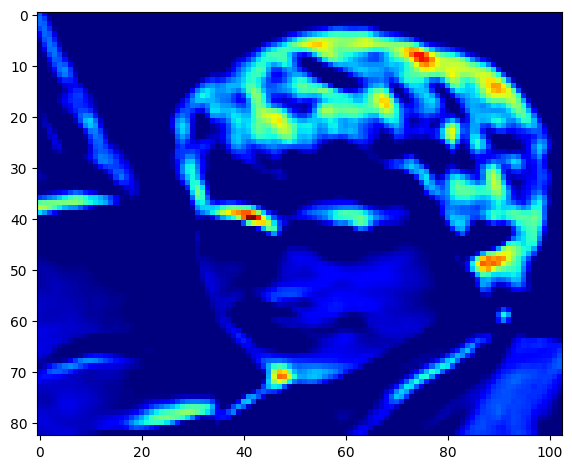

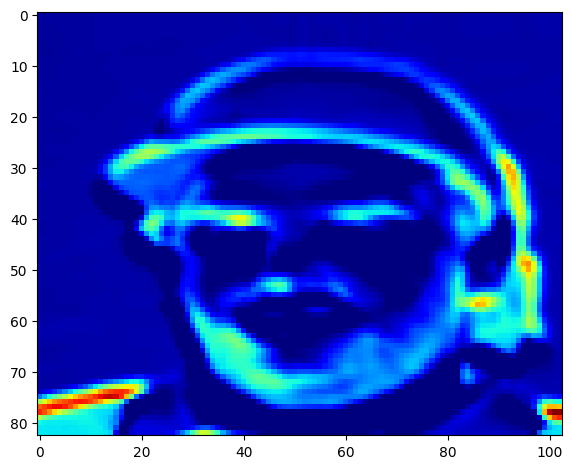

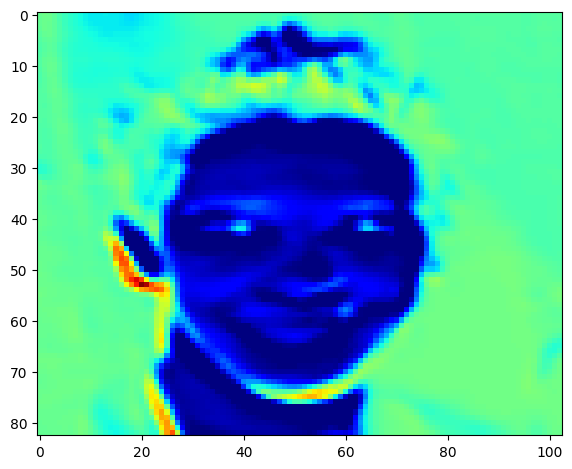

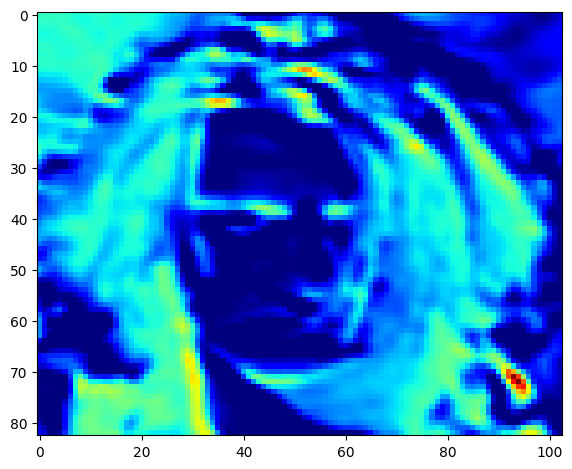

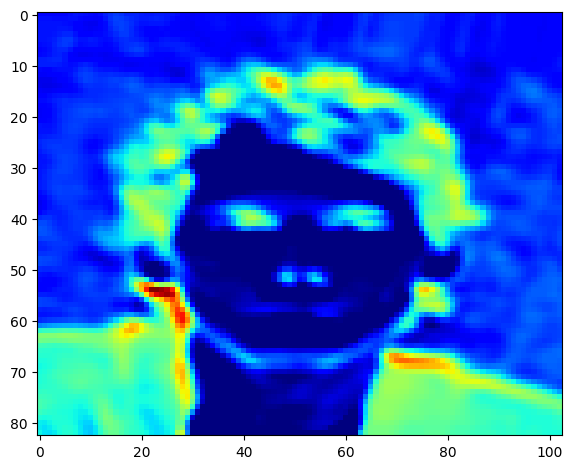

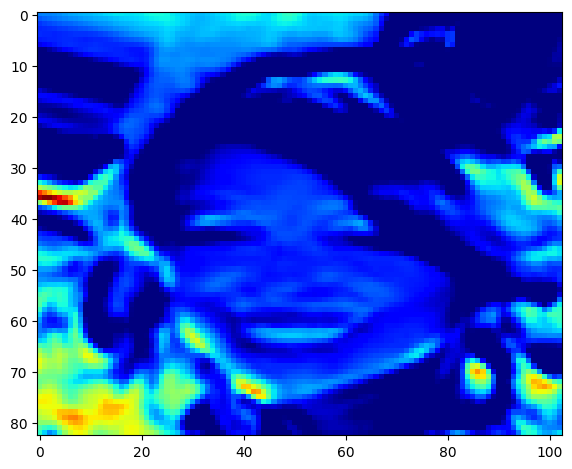

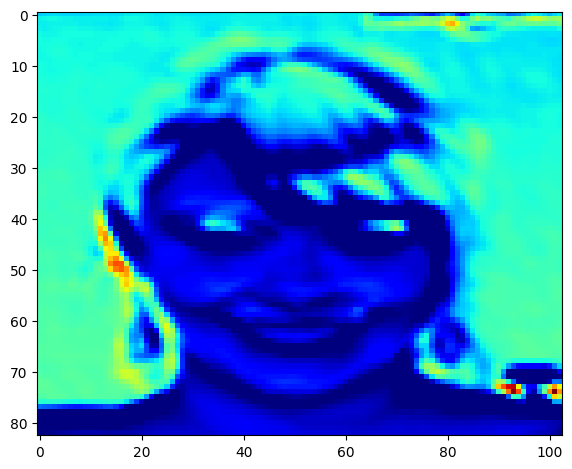

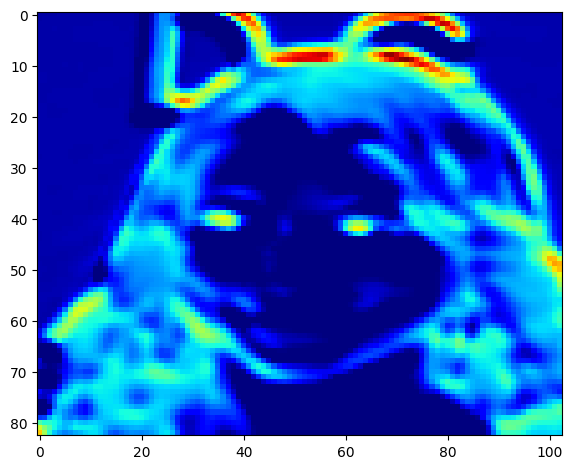

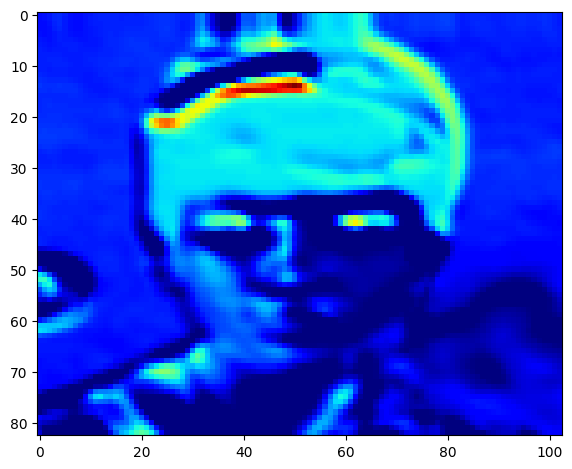

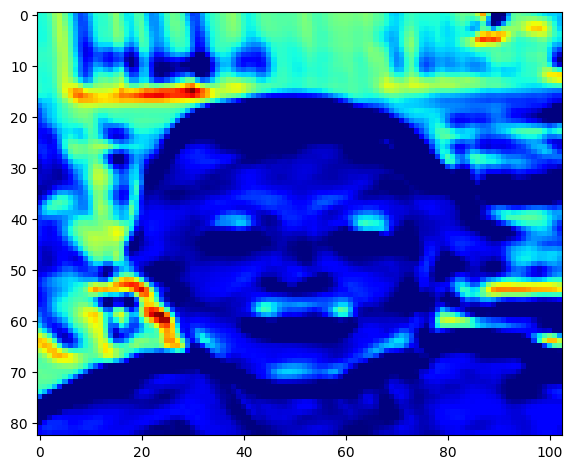

In [40]:
import os
import random

# Verzeichnisse für Männer und Frauen
men_dir = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\output\train\men"
women_dir = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\output\train\women"

# Liste der Bildpfade
men_images = [os.path.join(men_dir, img) for img in os.listdir(men_dir)]
women_images = [os.path.join(women_dir, img) for img in os.listdir(women_dir)]

# Wählen Sie 5 zufällige Bilder aus jedem Ordner aus
selected_images = random.sample(men_images, 5) + random.sample(women_images, 5)

for i, img_path in enumerate(selected_images):
    img = torchvision.io.read_image(img_path)
    input_tensor = torchvision.transforms.functional.normalize(
        torchvision.transforms.functional.resize(img, (178, 218)) / 255.,
        [0.485, 0.456, 0.406],
        [0.220, 0.224, 0.225]
    )

    # Führen Sie Ihr Modell mit dem Eingabebild aus
    out = model(input_tensor.unsqueeze(0))

    # Rufen Sie den CAM-Extraktor mit dem Klassenindex und dem Modellausgang auf
    activation_map = cam_extractor(1, out)

    # Konvertieren Sie die Aktivierungskarte in ein numpy ndarray
    activation_map = activation_map[0].squeeze(0).numpy()

    # Visualisieren Sie die Aktivierungskarte
    plt.imshow(activation_map, cmap='jet')
    plt.axis('on')
    plt.tight_layout()
    
    # Speichern Sie das Bild
    plt.savefig(rf'C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\model\activation_map\activation_map_{i}.png')

    plt.show()

In [ ]:
# import os
# import cv2


# # Pfad zum Ordner
# folder_path1 = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\output2\train\men"
# folder_path2 = r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\data\output2\train\women"


# def activation_map_vis(folder_path,label="Bild"):
#     # Liste der .jpg-Dateien im Ordner erstellen
    
#     jpg_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]

#     # Über die ersten 5 .jpg-Dateien iterieren
#     for i in range(min(5, len(jpg_files))):
#         img_path = os.path.join(folder_path, jpg_files[i])
        
#         # Lesen Sie Ihr Eingabebild ein und verarbeiten Sie es für Ihr Modell
#         img = torchvision.io.read_image(img_path)
#         input_tensor = torchvision.transforms.functional.normalize(
#             torchvision.transforms.functional.resize(img, (178, 218)) / 255.,
#             [0.485, 0.456, 0.406],
#             [0.220, 0.224, 0.225]
#         )

#         # Führen Sie Ihr Modell mit dem Eingabebild aus
#         out = model(input_tensor.unsqueeze(0))

#         # Rufen Sie den CAM-Extraktor mit dem Klassenindex und dem Modellausgang auf
#         activation_map = cam_extractor(1, out)

#         # Konvertieren Sie die Aktivierungskarte in ein numpy ndarray
#         activation_map = activation_map[0].squeeze(0).numpy()
#         # Skalieren Sie die Aktivierungskarte auf die Größe des Originalbildes
#         activation_map_resized = cv2.resize(activation_map, (img.shape[2], img.shape[1]))

#         # Visualisieren Sie das Originalbild
#         plt.imshow(img.permute(1, 2, 0))

#         # Visualisieren Sie die skalierte Aktivierungskarte
#         # plt.imshow(activation_map_resized, cmap='jet', alpha=0.5)

#         # Visualisieren Sie die Aktivierungskarte
#         plt.title(label)
#         # plt.imshow(activation_map, cmap='jet')
#         plt.imshow(activation_map_resized, cmap='jet', alpha=0.5)
#         plt.axis('off')
#         plt.tight_layout()
#         plt.show()


# activation_map_vis(folder_path1, label="Mann Bild")
# activation_map_vis(folder_path2, label="Frau Bild")

In [ ]:


# plt.axis('off')
# plt.show()